## Metric Calculations

In [46]:
from imports import (
    np, pd, xr, plt, os, LinearRegression,
    metrics, sys, Axes3D)

import fnmatch
from functions import regress_1d
from classes import SLF_Metric

%matplotlib inline

In [47]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
case_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(case_dir)
print('Can access all directory paths:', access_paths)

Running on storm.uio.no, attempting to mount ns9600k/jonahks/ from NIRD
Can access all directory paths: True


In [48]:
#all_cases = os.listdir('/home/jonahks/drivemount/mnth15runs/')
all_cases = os.listdir(case_dir)

all_cases

['20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 'error_vs_iso.png',
 'unused',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 'runs_as_vectors.png',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 'paramspace.png',
 '20191122_161009_sampleparamset_wbf_1_inp_1']

In [49]:
base_case = '20191122_161009_sampleparamset_wbf_1_inp_1'
cases = ['20191127_162007_sampleparamset_wbf_0.01_inp_1', 
         '20191122_161009_sampleparamset_wbf_1_inp_1',
#         '20191128_171713_sampleparamset_wbf_1_inp_10',
         '20191128_171713_sampleparamset_wbf_10_inp_1',
         '20191210_152149_sampleparamset_wbf_1_inp_10',
         '20191210_152149_sampleparamset_wbf_1_inp_0.1',
         '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
         '20191217_134307_singleparam_jolt_wbf_1_inp_0']

In [50]:
test = SLF_Metric(case_dir)

for i in cases:
    test.add_case(i)
test.set_origin(base_case)

In [41]:
metric_cases = test.get_cases()

In [42]:
key1 = list(metric_cases.keys())[1]
basecase_obj = metric_cases[key1]
_df = basecase_obj.case_ds
_df
#_df.drop(0.0)

,CALIOP_10N-10S,CALIOP_10S-30S,CALIOP_30N-10N,CALIOP_30S-50S,CALIOP_50N-30N,CALIOP_50S-70S,CALIOP_70N-50N,CALIOP_70S-90S,CALIOP_90N-70N,CALIOP Average,...,NorESM_10S-30S,NorESM_30N-10N,NorESM_30S-50S,NorESM_50N-30N,NorESM_50S-70S,NorESM_70N-50N,NorESM_70S-90S,NorESM_90N-70N,Arctic Error,Global Error
Isotherm,,,,,,,,,,,,,,,,,,,,,
-40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.649523,0.701112,0.734191,0.762072,0.910711,0.676523,1.686440,0.561619,0.561619,0.714611
-30.0,4.0,6.0,5.0,7.0,3.0,9.0,5.0,12.0,6.0,5.578054,...,5.272700,5.793299,6.189978,6.756526,12.026680,8.753282,14.389367,8.948410,2.948410,1.445471
-20.0,26.0,32.0,28.0,30.0,21.0,37.0,26.0,39.0,31.0,28.670216,...,11.964153,12.054469,15.180630,14.878921,28.873837,20.999265,25.780514,20.709251,-10.290749,-13.107442
-10.0,62.0,64.0,63.0,60.0,56.0,70.0,56.0,61.0,55.0,61.357769,...,30.198966,30.272848,42.999595,32.691968,50.902777,42.500702,44.331243,46.999692,-8.000308,-26.125227


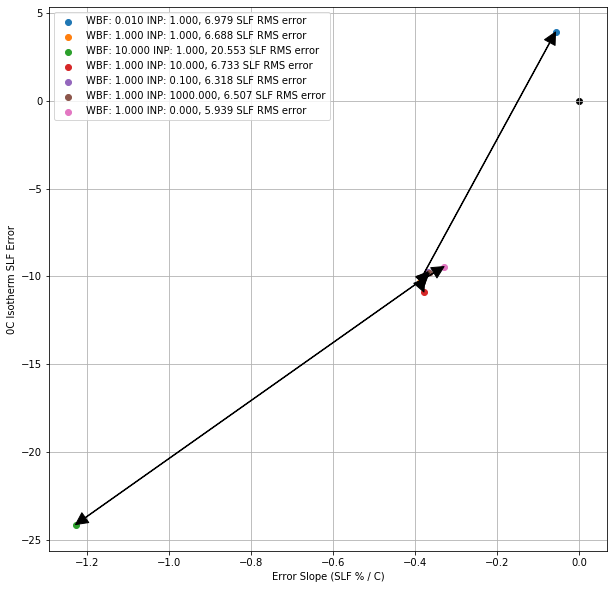

In [51]:
_temp = test.plot_vectors()

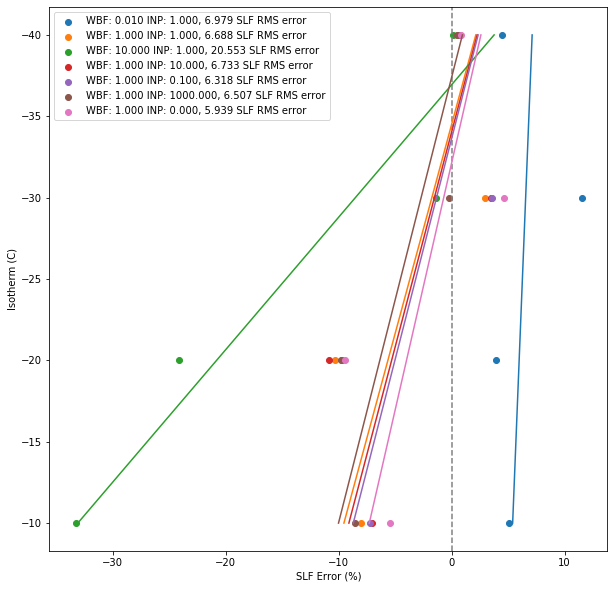

In [52]:
_temp = test.plot_isos()
#_temp.axes[0].axvline(color='grey', linestyle='--') #, x=0, ymin=0, ymax=1, **kwargs)

In [53]:
_temp = test.plot_parameterspace()
#_temp.set_xlims(1e-3,1e2)

ValueError: Image size of 617x102381 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x720 with 1 Axes>

0.01 1.0
1.0 1.0
10.0 1.0
1.0 10.0
1.0 0.1


<Figure size 432x288 with 0 Axes>

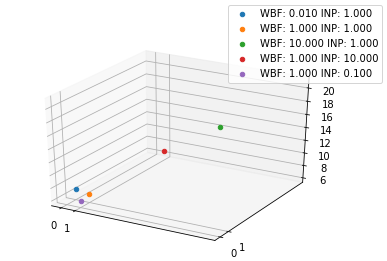

In [12]:
origin = [test.get_origin().wbf_mult, test.get_origin().inp_mult] # origin point (x,y)

plt.figure(1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


#ax.yaxis.set_scale('log')
#ax.xaxis.set_scale('log')
#ax.yscale('log')
#ax.xscale('log')
#plt.yscale('log')
#plt.xscale('log')
enablelog=True

if enablelog:
    xticks = [1e-3,1e-2,1e-1,1e0,1e1]
    yticks = [1e-3,1e-2,1e-1,1e0,1e1]

    ax.set_xticks(np.log10(xticks))
    ax.set_yticks(np.log10(yticks))
#    ax.set_xlimits((0.01,10))

#    ax.set_xticklabels(xticks)
#    ax.set_yticklabels(yticks)

metric_cases = test.get_cases()
for i in metric_cases:
    _case = metric_cases[i]

    label = 'WBF: %.3f INP: %.3f' % (_case.wbf_mult, _case.inp_mult)
    print(_case.wbf_mult, _case.inp_mult)
    _wbf, _inp, _rms = _case.wbf_mult, _case.inp_mult, _case.rms_error

    # xy is the endpoint, xytext is the origin
#    plt.annotate('', xy=(_wbf, _inp), xytext=(origin[0], origin[1]), 
#                arrowprops=dict(facecolor='black', shrink=0., width=0.5, lw=1.0),
#                )
    ax.scatter(_wbf, _inp, _rms, label=label)

fig.legend()